In [ ]:
import waveletec as wEC

wEC.run_from_eddypro(
    path="input/EP/FR-Gri_sample.eddypro", 
    output_folderpath="output/wavelet_flux",
    datetimerange="20220513T0000-20220516T0000",
    processing_time_duration="3h",
    covariance=["w*co2|w*h2o"],
    )

wEC.integrate_cospectra_from_file(
    "output/wavelet_flux/wavelet_full_cospectra",
    f0=1/30,
    dst_path="output/wavelet_flux/FR-Gri_sample_CDWT_full_cospectra.csv",
)

wEC.condition_sampling_partition(
    folder="output/wavelet_flux",
    output_name="FR-Gri_sample_CDWT_partitioning",
)

In [7]:
"""Make one unified dataset"""
import pandas as pd
import re

# I NEED TO CREATE A FLUXNET_like OUTPUT

fluxnet_data = pd.read_csv('output/eddypro_FR-Gri_sample_fluxnet_2024-04-24T111754_adv.csv')
fluxnet_data['TIMESTAMP'] = pd.to_datetime(fluxnet_data['TIMESTAMP_START'], format='%Y%m%d%H%M')
wavelet_data = pd.read_csv('output/wavelet_flux/FR-Gri_sample_CDWT_full_cospectra.csv')
wavelet_data['TIMESTAMP'] = pd.to_datetime(wavelet_data['TIMESTAMP'])
partitd_data = pd.read_csv('output/wavelet_flux/FR-Gri_sample_CDWT_partitioning.CO2_H2O.csv')
partitd_data['TIMESTAMP'] = pd.to_datetime(partitd_data['TIMESTAMP'])

# Load data and compute datetime hours
all_flux_data = fluxnet_data.copy()
all_flux_data = pd.merge(all_flux_data, wavelet_data, on='TIMESTAMP', how='inner', suffixes=('', '_WL'))
all_flux_data = pd.merge(all_flux_data, partitd_data, on='TIMESTAMP', how='inner', suffixes=('', '_PT'))
all_flux_data['HH'] = (all_flux_data['TIMESTAMP'] - all_flux_data['TIMESTAMP'].dt.floor('1D')) / pd.Timedelta('1h')
all_flux_data['MM'] = all_flux_data.TIMESTAMP.dt.month.astype(str) + '/' + all_flux_data.TIMESTAMP.dt.year.astype(str)

# Convert covariance to flux
wavelet_plus = []
for c in set(all_flux_data.columns) - set(fluxnet_data.columns):
    if re.findall('_[0-9]+$', c) or c.endswith('qc'): continue
    # depends of the unit (h2o changes from run to run)
    if c[:3] in ['wco', 'wch', 'wn2']:
        gas_correction = (1 / all_flux_data.DRYAIR_MV)
        wavelet_plus += [pd.DataFrame({'F_UNCORR_'+c: all_flux_data[c] * gas_correction})]
        wavelet_plus   += [pd.DataFrame({'F_'+c:      all_flux_data[c]  * gas_correction * all_flux_data[f'FC_SCF']})]
    elif c[:3] in ['wts']:
        heat_correction = all_flux_data.AIR_DENSITY * all_flux_data.AIR_CP
        wavelet_plus += [pd.DataFrame({'F_UNCORR_'+c: all_flux_data[c] * heat_correction})]
        wavelet_plus += [pd.DataFrame({'F_'+c:        all_flux_data[c] * heat_correction * all_flux_data[f'H_SCF']})]
    elif c[:4] in ['wh2o']:
        water_correction = 10**-3 * (10**3 * (3147.5 - 2.37 * all_flux_data.TA_EP)) * 0.01802 / all_flux_data.DRYAIR_MV
        wavelet_plus += [pd.DataFrame({'F_UNCORR_'+c: all_flux_data[c] * water_correction})]
        wavelet_plus += [pd.DataFrame({'F_'+c:        all_flux_data[c] * water_correction * all_flux_data[f'LE_SCF']})]
    elif c[:3] in ['NEE', 'GPP', 'Rec']:
        gas_correction = (1 / all_flux_data.DRYAIR_MV)
        wavelet_plus += [pd.DataFrame({'F_UNCORR_'+c: all_flux_data[c] * gas_correction})]
        wavelet_plus   += [pd.DataFrame({'F_'+c:      all_flux_data[c]  * gas_correction * all_flux_data[f'FC_SCF']})]

# Concatenate converted columns to main data
all_flux_data = all_flux_data = pd.concat([all_flux_data] + wavelet_plus, axis=1).copy()


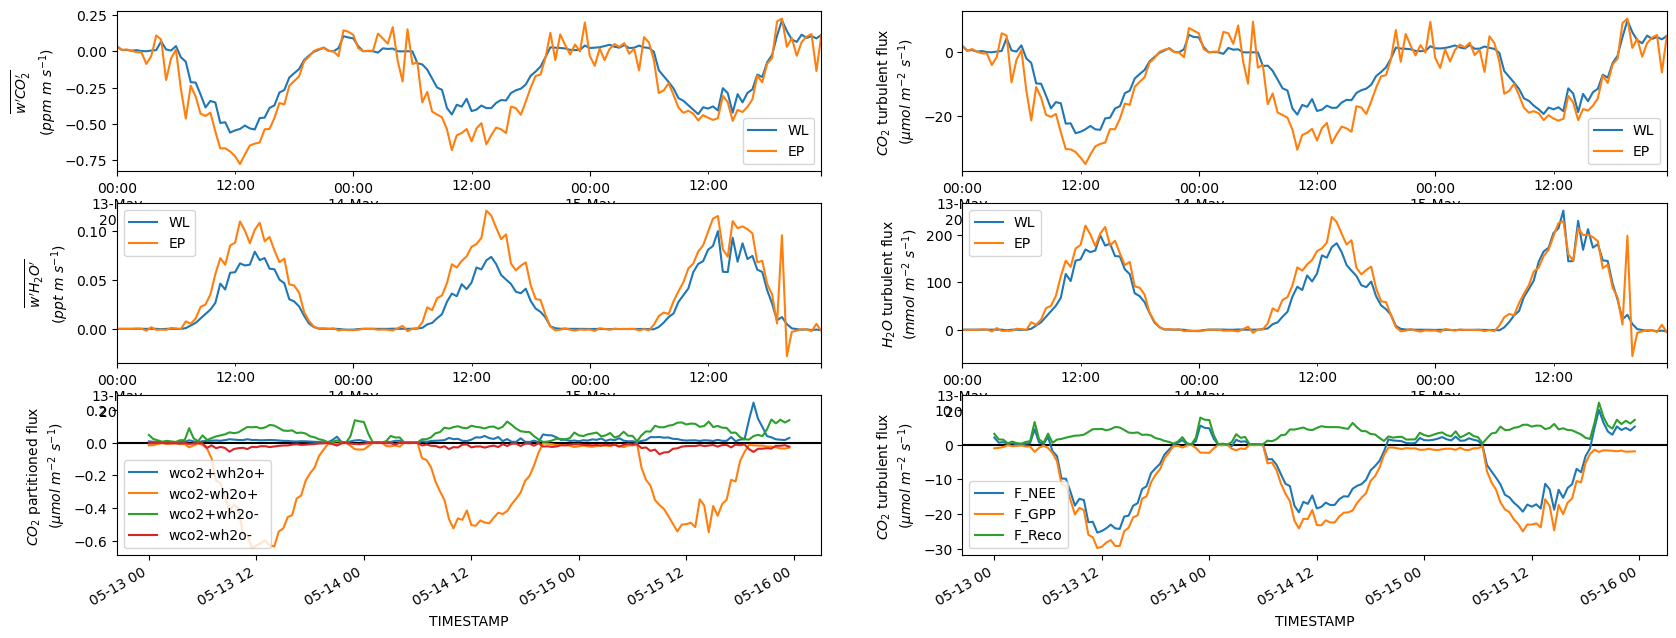

In [8]:
from matplotlib import pyplot as plt

plt.figure(1, figsize=(20,8))

plt.subplot(321)
all_flux_data[['TIMESTAMP', 'wco2', 'W_CO2_MEAS_COV']].rename(columns={'wco2': 'WL', 'W_CO2_MEAS_COV': 'EP'}).plot(x='TIMESTAMP', ylabel=r"$\overline{w'CO_2'}$" +"\n"+ r"($ppm\ m\ s^{-1}$)", ax=plt.gca())
plt.subplot(322)
all_flux_data[['TIMESTAMP', 'F_wco2', 'FC']].rename(columns={'F_wco2': 'WL', 'FC': 'EP'}).plot(x='TIMESTAMP', ylabel=r'$CO_2$ turbulent flux' +'\n'+ r'($μmol\ m^{-2}\ s^{-1}$)', ax=plt.gca())

plt.subplot(323)
all_flux_data[['TIMESTAMP', 'wh2o', 'W_H2O_MEAS_COV']].rename(columns={'wh2o': 'WL', 'W_H2O_MEAS_COV': 'EP'}).plot(x='TIMESTAMP', ylabel=r"$\overline{w'H_2O'}$" +"\n"+ r"($ppt\ m\ s^{-1}$)", ax=plt.gca())
plt.subplot(324)
all_flux_data[['TIMESTAMP', 'F_wh2o', 'LE']].rename(columns={'F_wh2o': 'WL', 'LE': 'EP'}).plot(x='TIMESTAMP', ylabel=r'$H_2O$ turbulent flux' +'\n'+ r'($mmol\ m^{-2}\ s^{-1}$)', ax=plt.gca())

plt.subplot(325)
plt.axhline(0, c='k')
all_flux_data[['TIMESTAMP', 'wco2+wh2o+', 'wco2-wh2o+', 'wco2+wh2o-', 'wco2-wh2o-']].plot(x='TIMESTAMP', ylabel=r'$CO_2$ partitioned flux' +'\n'+ r'($μmol\ m^{-2}\ s^{-1}$)', ax=plt.gca())
plt.subplot(326)
plt.axhline(0, c='k')
all_flux_data[['TIMESTAMP', 'F_NEE', 'F_GPP', 'F_Reco']].plot(x='TIMESTAMP', ylabel=r'$CO_2$ turbulent flux' +'\n'+ r'($μmol\ m^{-2}\ s^{-1}$)', ax=plt.gca())
plt.show()
